## Task 1 - Scrapping Data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

#### Getting the source webpage and assigining the variable source to it and iniatilizing the beautifulsoup object to soup

In [29]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

resp = requests.get(url)
toronto_html = BeautifulSoup(resp.content)

In [30]:
soup = BeautifulSoup(str(toronto_html))
neighborhood_table = soup.find('table')
table_str = str(neighborhood_table.extract())
toronto_df = pd.read_html(table_str)[0]
toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Pre-Processing

In [31]:
toronto_df.columns = ['PostalCode'] + list(toronto_df.columns)[1:]

In [32]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [33]:
toronto_df.shape

(180, 3)

Removing empty cells with Borough

In [34]:
toronto_df.Borough.value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 5
Mississauga          1
Name: Borough, dtype: int64

In [35]:
borough_na = toronto_df[toronto_df.Borough == 'Not assigned']
toronto_df.drop(borough_na.index, inplace=True)
toronto_df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [36]:
toronto_df.shape

(103, 3)

In [37]:
toronto_df = toronto_df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).to_frame()

In [38]:
toronto_df.reset_index(inplace=True)
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [40]:
toronto_df[toronto_df.Neighborhood == "Not assigned"]

,PostalCode,Borough,Neighborhood


#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [41]:
toronto_df.loc[85, 'Neighborhood'] = toronto_df.loc[85, 'Borough']
toronto_df[toronto_df.Neighborhood == "Not assigned"]

,PostalCode,Borough,Neighborhood


In [42]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [43]:
toronto_df.shape

(103, 3)

## Task 2 - Getting Geospatial Data

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In [44]:
geo_url = "https://cocl.us/Geospatial_data"

geocode_df = pd.read_csv(geo_url)
geocode_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geocode_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [45]:
toronto_df = pd.merge(toronto_df, geocode_df, on='PostalCode')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Task 3 - Analysis of Data

In [46]:
toronto_latlong = [43.653225, -79.383186]


In [47]:
# create map of Manhattan using latitude and longitude values
toronto_map = folium.Map(location=toronto_latlong, zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#2E7D32',
        fill=True,
        fill_color='#FFEB3B',
        fill_opacity=0.75,
        parse_html=False).add_to(toronto_map)

## Four Square Api

In [48]:
search_url = 'https://api.foursquare.com/v2/venues/search'

### My Credientials
   I have hidden my credientials on github.

In [50]:
CLIENT_ID = 'CEUNJMYLNWJGKPANZIHEA3QZDQCTVUJDJXLZDUZ2QCJLKJ5I' # your Foursquare ID
CLIENT_SECRET = 'OPMQTV1FWBLSRM2AKW2L3EI25KGYVDRJRDJX1RVNOHOH3VLI' # your Foursquare Secret
VERSION = '20180604'


####  Let's explore one of the boroughs in our dataframe.

In [51]:
toronto_df.loc[0, 'Borough']

'Scarborough'

In [52]:
print('Latitude and longitude values of {} are {}, {}.'.format(toronto_df.loc[0, 'Borough'], 
                                                               toronto_df.loc[0, 'Latitude'], 
                                                               toronto_df.loc[0, 'Longitude']))

Latitude and longitude values of Scarborough are 43.806686299999996, -79.19435340000001.


#### Now, let's explore the Foursquare API using Scarborough

In [54]:
params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v=VERSION,
  ll=f"{toronto_df.loc[0, 'Latitude']}, {toronto_df.loc[0, 'Longitude']}",
  radius=500,
  limit=100
)

In [55]:
resp = requests.get(url=search_url, params=params)
data = resp.json()

In [56]:
data['response']['venues'][0]

{'id': '4e389459b61c438b547e8ed4',
 'name': 'Rouge Park - Woodland Trail',
 'location': {'lat': 43.80178186082014,
  'lng': -79.20042735921538,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.80178186082014,
    'lng': -79.20042735921538}],
  'distance': 732,
  'cc': 'CA',
  'country': 'Canada',
  'formattedAddress': ['Canada']},
 'categories': [{'id': '4bf58dd8d48988d159941735',
   'name': 'Trail',
   'pluralName': 'Trails',
   'shortName': 'Trail',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/hikingtrail_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1593893962',
 'hasPerk': False}

 Now, let's write a function to extract important data from venue object. We can reuse the function for other boroughs as well intead of repeating the same code again and again.

In [61]:
def get_venues(neighborhood, lat, long, limit=100, radius=250):
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll=f"{lat}, {long}",
        radius=radius,
        limit=limit
    )
    venues = []
    data = requests.get(url=search_url, params=params).json()
    for v in data['response']['venues']:
        venues.append([neighborhood, lat, long, v['name'], v['location']['lat'], v['location']['lng'], 
                       ', '.join(x['name'] for x in v['categories'])])
    return venues

In [62]:
nbr_venues_df = pd.DataFrame()
columns=['Neighborhood', 'NeighborhoodLat', 'NeighborhoodLong', 'VenueName', 'VenueLat', 'VenueLong', 'VenueCategory']

In [63]:
for name, lat, long in zip(toronto_df.Neighborhood, toronto_df.Latitude, toronto_df.Longitude):
    nbr_venues_df = nbr_venues_df.append(get_venues(name, lat, long))

In [64]:
nbr_venues_df.columns = columns

In [65]:
nbr_venues_df.head()

,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Malvern, Rouge",43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail
1,"Malvern, Rouge",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
2,"Malvern, Rouge",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
3,"Malvern, Rouge",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
4,"Malvern, Rouge",43.806686,-79.194353,Subway,43.801095,-79.200304,Sandwich Place


In [66]:
nbr_venues_df.shape

(9867, 7)

Saving the data to CSV file

In [67]:
nbr_venues_df.to_csv('toronto_boroughs_and_venues.csv')

## Analysis of Venue Data

In [68]:
nbr_venues_df = pd.read_csv('toronto_boroughs_and_venues.csv')
nbr_venues_df.drop(['Unnamed: 0'], axis=1, inplace=True)
nbr_venues_df.head()

,Neighborhood,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Malvern, Rouge",43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail
1,"Malvern, Rouge",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
2,"Malvern, Rouge",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
3,"Malvern, Rouge",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
4,"Malvern, Rouge",43.806686,-79.194353,Subway,43.801095,-79.200304,Sandwich Place


In [69]:
nbr_venues_df.VenueCategory.replace('', np.nan, inplace=True)
nbr_venues_df.dropna(inplace=True)
nbr_venues_df.shape

(8795, 7)

In [70]:
nbr_venues_df.VenueCategory.value_counts()

Office                                      390
Residential Building (Apartment / Condo)    306
Salon / Barbershop                          205
Park                                        194
Building                                    191
                                           ... 
College Track                                 1
Internet Cafe                                 1
Chinese Breakfast Place                       1
Boxing Gym                                    1
Volleyball Court                              1
Name: VenueCategory, Length: 507, dtype: int64

Let's drop the venue categories which are not common, since they may add too much noise to our data

In [71]:
common_categories = nbr_venues_df.VenueCategory.unique()[nbr_venues_df.VenueCategory.value_counts()>15]

In [72]:
nbr_venues_df = nbr_venues_df[nbr_venues_df.VenueCategory.isin(common_categories)]
nbr_venues_df.shape

(6345, 7)

#### Analyzing how many venues are present in the every neighboorhood.

In [73]:
from IPython.core.display import HTML

display(HTML(nbr_venues_df.groupby('Neighborhood').count().to_html()))

,NeighborhoodLat,NeighborhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
Neighborhood,,,,,,
Agincourt,77,77,77,77,77,77
"Alderwood, Long Branch",66,66,66,66,66,66
"Bathurst Manor, Wilson Heights, Downsview North",66,66,66,66,66,66
Bayview Village,72,72,72,72,72,72
"Bedford Park, Lawrence Manor East",64,64,64,64,64,64
Berczy Park,56,56,56,56,56,56
"Birch Cliff, Cliffside West",62,62,62,62,62,62
"Brockton, Parkdale Village, Exhibition Place",76,76,76,76,76,76
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",46,46,46,46,46,46


In [74]:
nbr_venues_df.groupby('Neighborhood').count().VenueCategory.min()

13

So, for clustering, we will consider Top 10 venue categories in each neighborhood as features.

We will do one-hot encoding of the VenueCategory column to convert them to features

In [75]:
# add neighborhood column back to dataframe
category_onehot = pd.get_dummies(nbr_venues_df.VenueCategory)
category_onehot['Neighborhood'] = nbr_venues_df.Neighborhood

# move neighborhood column to the first column
fixed_columns = [category_onehot.columns[-1]] + list(category_onehot.columns[:-1])
category_onehot = category_onehot[fixed_columns]
category_onehot.head()

,Neighborhood,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Tattoo Parlor,Tech Startup,Temple,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Video Store,Winery,Zoo Exhibit
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
category_onehot.shape

(6345, 134)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [77]:
category_onehot = category_onehot.groupby('Neighborhood').mean().reset_index()
category_onehot

,Neighborhood,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Tattoo Parlor,Tech Startup,Temple,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Video Store,Winery,Zoo Exhibit
0,Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.025974,0.025974,0.168831,...,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.000000,0.015152,0.030303,0.000000,0.015152,0.015152,0.000000,0.015152,...,0.000000,0.000000,0.000000,0.015152,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,Bayview Village,0.0,0.000000,0.000000,0.027778,0.013889,0.000000,0.000000,0.000000,0.013889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.015625,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,"Willowdale, Willowdale West",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
95,Woburn,0.0,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.000000,0.011364,...,0.000000,0.000000,0.000000,0.000000,0.011364,0.022727,0.0,0.000000,0.0,0.0
96,Woodbine Heights,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051724,...,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.0,0.017241,0.0,0.0
97,York Mills West,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.015385,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


#### Let's print each neighborhood along with the top 5 most common venues

In [78]:
num_top_venues = 5

for nbrhood in category_onehot['Neighborhood']:
    print("---- "+nbrhood+" ----")
    temp = category_onehot[category_onehot['Neighborhood'] == nbrhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
             venue  freq
0  Automotive Shop  0.17
1         Building  0.09
2           Office  0.09
3      Coffee Shop  0.04
4           Church  0.04


---- Alderwood, Long Branch ----
                venue  freq
0              Office  0.08
1    Dentist's Office  0.05
2                Bank  0.05
3   Convenience Store  0.05
4  Salon / Barbershop  0.05


---- Bathurst Manor, Wilson Heights, Downsview North ----
                                      venue  freq
0                           Doctor's Office  0.11
1                            Medical Center  0.08
2                                      Bank  0.06
3  Residential Building (Apartment / Condo)  0.06
4                        Salon / Barbershop  0.05


---- Bayview Village ----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.08
1                                    Church  0.08
2                           Doctor's Office  0.07
3                        Salon / Barber

#### Let's put that into a pandas dataframe

In [79]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [80]:
indicators = ['st', 'nd', 'rd']
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nbr_venues_sorted_df = pd.DataFrame(columns=columns)
nbr_venues_sorted_df['Neighborhood'] = category_onehot['Neighborhood']

for ind in np.arange(category_onehot.shape[0]):
    nbr_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(category_onehot.iloc[ind, :], num_top_venues)

nbr_venues_sorted_df.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Automotive Shop,Office,Building,Church,Chinese Restaurant,Coffee Shop,Factory,Furniture / Home Store,Gas Station,General Entertainment
1,"Alderwood, Long Branch",Office,Salon / Barbershop,Bank,Dentist's Office,Convenience Store,Gas Station,Spa,Pizza Place,Playground,Café
2,"Bathurst Manor, Wilson Heights, Downsview North",Doctor's Office,Medical Center,Residential Building (Apartment / Condo),Bank,Spa,Office,Convenience Store,Salon / Barbershop,Laundry Service,Church
3,Bayview Village,Residential Building (Apartment / Condo),Church,Salon / Barbershop,Doctor's Office,Office,Bank,Playground,Café,School,Pharmacy
4,"Bedford Park, Lawrence Manor East",Salon / Barbershop,Italian Restaurant,Spa,Furniture / Home Store,Restaurant,Coffee Shop,Café,Mobile Phone Shop,Clothing Store,Dentist's Office


## Clustering Neighborhoods

In [81]:
from sklearn.cluster import KMeans

Let's assume we can cluster neighborhoods into three types based on venue categories. We will use 'Elbow' method later to find the best number of clusters

In [82]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)

In [83]:
X = category_onehot.drop(['Neighborhood'], axis=1)
X.head()

,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,...,Tattoo Parlor,Tech Startup,Temple,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Video Store,Winery,Zoo Exhibit
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.025974,0.025974,0.168831,0.012987,...,0.0,0.012987,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.015152,0.030303,0.000000,0.015152,0.015152,0.000000,0.015152,0.030303,...,0.0,0.000000,0.0,0.015152,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.027778,0.013889,0.000000,0.000000,0.000000,0.013889,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([2, 1, 1, 1, 1, 2, 1, 0, 2, 2])

In [85]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [86]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

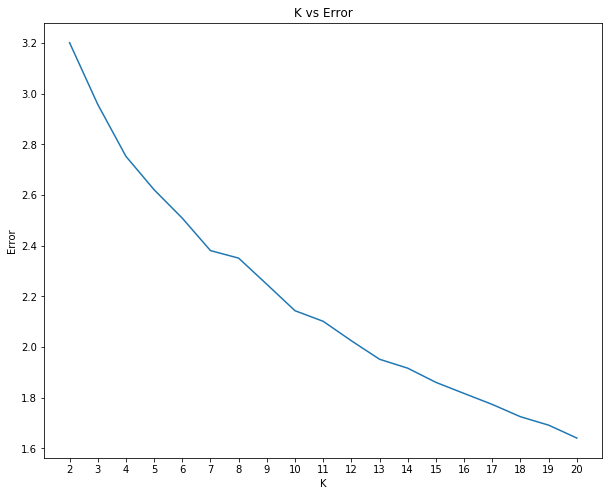

In [87]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

From the above visualization, we can say that the speed at which error reduces falls after K=9

In [88]:
# train final model with k=9
kmeans = KMeans(n_clusters=9)
kmeans.fit(X)

KMeans(n_clusters=9)

In [89]:
kmeans.labels_[:10]

array([8, 3, 7, 7, 1, 3, 3, 6, 3, 3])

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [90]:
# add clustering labels
nbr_venues_sorted_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [91]:
toronto_nbr_df = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_nbr_df = toronto_nbr_df.join(nbr_venues_sorted_df.set_index('Neighborhood'), on='Neighborhood')

toronto_nbr_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,8,Automotive Shop,Office,Factory,Building,Salon / Barbershop,Doctor's Office,Dentist's Office,Coffee Shop,Caribbean Restaurant,Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,8,Automotive Shop,Park,Office,Medical Center,General Entertainment,Salon / Barbershop,Nail Salon,Bar,Laundry Service,Church
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,7,Residential Building (Apartment / Condo),Electronics Store,Restaurant,Church,Bank,Building,Medical Center,Tech Startup,School,Bus Line
3,M1G,Scarborough,Woburn,43.770992,-79.216917,7,Cosmetics Shop,Pizza Place,Convenience Store,Indian Restaurant,Residential Building (Apartment / Condo),Coffee Shop,Church,Pharmacy,Salon / Barbershop,Building
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Building,Bakery,Medical Center,Doctor's Office,Caribbean Restaurant,Sporting Goods Shop,Residential Building (Apartment / Condo),Automotive Shop,Laundry Service,Pharmacy


#### Finally, let's visualize the resulting clusters

In [92]:
# create map
map_clusters = folium.Map(location=toronto_latlong, zoom_start=11)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_nbr_df['Latitude'], toronto_nbr_df['Longitude'], toronto_nbr_df['Neighborhood'], toronto_nbr_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [93]:
HTML(map_clusters._repr_html_())

## Examining Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

### Cluster 0

In [94]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 0, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",0,Clothing Store,Optical Shop,Cosmetics Shop,Doctor's Office,Jewelry Store,Restaurant,Bank,Furniture / Home Store,Sporting Goods Shop,Men's Store
71,"Lawrence Manor, Lawrence Heights",0,Clothing Store,Furniture / Home Store,Miscellaneous Shop,Design Studio,Office,Cosmetics Shop,Automotive Shop,Hardware Store,Spa,Event Space


### Cluster 1

In [95]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 1, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Leaside,1,Bank,Furniture / Home Store,Coffee Shop,Sporting Goods Shop,Sandwich Place,Auto Dealership,Auto Garage,Automotive Shop,Electronics Store,Salon / Barbershop
43,Studio District,1,Coffee Shop,Automotive Shop,Pharmacy,Nail Salon,Restaurant,Building,Café,Church,Dentist's Office,Furniture / Home Store
46,"North Toronto West, Lawrence Park",1,Clothing Store,Health & Beauty Service,Cosmetics Shop,Sporting Goods Shop,Men's Store,Furniture / Home Store,Arts & Crafts Store,Church,General Entertainment,Jewelry Store
47,Davisville,1,Coffee Shop,Italian Restaurant,Café,French Restaurant,Laundry Service,Library,Salon / Barbershop,Pizza Place,Thrift / Vintage Store,Spa
51,"St. James Town, Cabbagetown",1,Coffee Shop,Pharmacy,General Entertainment,Restaurant,Pizza Place,Café,Laundry Service,Spa,Convenience Store,Bakery
54,"Garden District, Ryerson",1,College Lab,Coffee Shop,Building,Salon / Barbershop,General Entertainment,Café,Church,School,Doctor's Office,Dentist's Office
57,Central Bay Street,1,Coffee Shop,Medical Center,Pharmacy,Fast Food Restaurant,Salon / Barbershop,Sandwich Place,Café,Japanese Restaurant,Rental Car Location,Residential Building (Apartment / Condo)
62,"Bedford Park, Lawrence Manor East",1,Salon / Barbershop,Italian Restaurant,Spa,Furniture / Home Store,Restaurant,Coffee Shop,Café,Mobile Phone Shop,Clothing Store,Dentist's Office
66,"University of Toronto, Harbord",1,Coffee Shop,College Gym,College Lab,Church,Building,Bank,Convenience Store,Sandwich Place,Chinese Restaurant,Café
70,"First Canadian Place, Underground city",1,Coffee Shop,Bakery,Clothing Store,Salon / Barbershop,Office,Cosmetics Shop,Sandwich Place,Restaurant,Event Space,Jewelry Store


### Cluster 2

In [96]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 2, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,"Moore Park, Summerhill East",2,Office,Residential Building (Apartment / Condo),Park,Building,Grocery Store,Gym,Gym / Fitness Center,Trail,Playground,Martial Arts Dojo
52,Church and Wellesley,2,Residential Building (Apartment / Condo),Spa,General Entertainment,Gym,Gym / Fitness Center,Office,Hotel,Bank,Miscellaneous Shop,Thrift / Vintage Store
59,"Harbourfront East, Union Station, Toronto Islands",2,Residential Building (Apartment / Condo),Office,Building,Coffee Shop,Fried Chicken Joint,Indian Restaurant,Doctor's Office,Pizza Place,Convenience Store,Middle Eastern Restaurant
63,Roselawn,2,Dentist's Office,Office,Spa,Playground,Residential Building (Apartment / Condo),Gym,General Entertainment,Medical Center,Doctor's Office,Italian Restaurant
64,"Forest Hill North & West, Forest Hill Road Park",2,Residential Building (Apartment / Condo),Office,Tech Startup,Gym / Fitness Center,General Entertainment,Doctor's Office,Park,Dentist's Office,Salon / Barbershop,Asian Restaurant
65,"The Annex, North Midtown, Yorkville",2,Residential Building (Apartment / Condo),Building,General Entertainment,Café,Office,Miscellaneous Shop,Park,Japanese Restaurant,Playground,Hotel


### Cluster 3

In [97]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 3, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Cedarbrae,3,Building,Bakery,Medical Center,Doctor's Office,Caribbean Restaurant,Sporting Goods Shop,Residential Building (Apartment / Condo),Automotive Shop,Laundry Service,Pharmacy
9,"Birch Cliff, Cliffside West",3,Church,Park,General Entertainment,Office,Laundry Service,Indian Restaurant,Government Building,Pizza Place,Restaurant,Bar
11,"Wexford, Maryvale",3,Middle Eastern Restaurant,Grocery Store,Coffee Shop,Office,Bakery,Pizza Place,Café,Dentist's Office,Burger Joint,Medical Center
16,Upper Rouge,3,Zoo Exhibit,Park,Office,Cosmetics Shop,Pizza Place,Playground,Trail,Athletics & Sports,Auto Dealership,Art Gallery
29,"Northwood Park, York University",3,Office,Automotive Shop,Furniture / Home Store,Pharmacy,Building,Gas Station,Salon / Barbershop,Miscellaneous Shop,Cosmetics Shop,Medical Center
35,"Parkview Hill, Woodbine Gardens",3,Bus Stop,Building,Office,Bank,Café,Dentist's Office,Convenience Store,Fast Food Restaurant,Residential Building (Apartment / Condo),Sandwich Place
39,Thorncliffe Park,3,Office,Residential Building (Apartment / Condo),Church,Bank,Indian Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Coffee Shop,Dentist's Office
44,Lawrence Park,3,Housing Development,School,Bus Line,Bank,General Entertainment,Fast Food Restaurant,Office,Park,Pool,Church
55,St. James Town,3,Office,Event Space,Residential Building (Apartment / Condo),Building,Laundry Service,Japanese Restaurant,Rental Car Location,Church,Clothing Store,Spa
56,Berczy Park,3,Building,Office,Residential Building (Apartment / Condo),Gym,Event Space,General Entertainment,Tech Startup,Lounge,Laundry Service,Hotel


### Cluster 4

In [98]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 4, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
85,Downtown Toronto,4,Government Building,Medical Center,Building,Restaurant,Office,Doctor's Office,Event Space,School,Café,Men's Store


### Cluster 5

In [99]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 5, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"York Mills, Silver Hills",5,Park,Residential Building (Apartment / Condo),Church,School,Pool,Middle Eastern Restaurant,Bus Line,Coffee Shop,Building,Library
23,York Mills West,5,Residential Building (Apartment / Condo),Gym,Office,Park,Church,Medical Center,Building,Event Space,Laundry Service,Bus Line
24,"Willowdale, Willowdale West",5,Residential Building (Apartment / Condo),Medical Center,Bank,Park,Pizza Place,Dentist's Office,Financial or Legal Service,Doctor's Office,Coffee Shop,Pool
25,Parkwoods,5,Residential Building (Apartment / Condo),Bus Stop,Park,Office,School,Elementary School,Convenience Store,Church,Pool,Spiritual Center
45,Davisville North,5,Residential Building (Apartment / Condo),Office,Gym,Hotel,Scenic Lookout,Building,Breakfast Spot,Playground,Park,Dentist's Office
49,"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park",5,Residential Building (Apartment / Condo),Office,Doctor's Office,Dentist's Office,Building,Medical Center,Café,Spiritual Center,Athletics & Sports,Government Building
50,Rosedale,5,Residential Building (Apartment / Condo),Office,Park,Trail,Bank,Salon / Barbershop,Government Building,General Travel,Music Venue,Clothing Store
91,"Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East",5,Residential Building (Apartment / Condo),Park,Office,Convenience Store,Elementary School,Bus Line,Grocery Store,School,Playground,Sporting Goods Shop


### Cluster 6

In [100]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 6, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Don Mills,6,Office,Medical Center,Building,Church,Café,Automotive Shop,Doctor's Office,Gym,Coworking Space,Coffee Shop
27,Don Mills,6,Office,Medical Center,Building,Church,Café,Automotive Shop,Doctor's Office,Gym,Coworking Space,Coffee Shop
60,"Toronto Dominion Centre, Design Exchange",6,Office,Coffee Shop,Restaurant,Park,Café,Pharmacy,Coworking Space,Cosmetics Shop,Building,Italian Restaurant
61,"Commerce Court, Victoria Hotel",6,Office,Financial or Legal Service,Salon / Barbershop,Coffee Shop,Bank,Bakery,Restaurant,Building,Dentist's Office,Café
69,Stn A PO Boxes,6,Office,Building,Residential Building (Apartment / Condo),Tech Startup,Bar,Gym,Hotel,Rental Car Location,Professional & Other Places,Café
78,"Brockton, Parkdale Village, Exhibition Place",6,Office,Residential Building (Apartment / Condo),Tech Startup,Café,Building,Coffee Shop,Bar,Convenience Store,Paper / Office Supplies Store,Playground
86,Canada Post Gateway Processing Centre,6,Office,Bus Line,Building,Chinese Restaurant,Convenience Store,Gym,Hotel,Coffee Shop,Pizza Place,Middle Eastern Restaurant


### Cluster 7

In [101]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 7, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Guildwood, Morningside, West Hill",7,Residential Building (Apartment / Condo),Electronics Store,Restaurant,Church,Bank,Building,Medical Center,Tech Startup,School,Bus Line
3,Woburn,7,Cosmetics Shop,Pizza Place,Convenience Store,Indian Restaurant,Residential Building (Apartment / Condo),Coffee Shop,Church,Pharmacy,Salon / Barbershop,Building
6,"Kennedy Park, Ionview, East Birchmount Park",7,Residential Building (Apartment / Condo),Grocery Store,Coffee Shop,Chinese Restaurant,Church,Bus Line,Pizza Place,Pharmacy,Office,Salon / Barbershop
7,"Golden Mile, Clairlea, Oakridge",7,Bus Line,Park,Residential Building (Apartment / Condo),Automotive Shop,Doctor's Office,Convenience Store,Bus Station,Chinese Restaurant,Pharmacy,Bakery
8,"Cliffside, Cliffcrest, Scarborough Village West",7,Pizza Place,Office,Residential Building (Apartment / Condo),Church,Salon / Barbershop,Convenience Store,Laundry Service,Dentist's Office,Gym / Fitness Center,Miscellaneous Shop
14,"Milliken, Agincourt North, Steeles East, L'Amoreaux East",7,School,Chinese Restaurant,Doctor's Office,Medical Center,Building,BBQ Joint,Park,Bakery,Church,Bus Line
15,"Steeles West, L'Amoreaux West",7,Chinese Restaurant,Bank,Doctor's Office,Salon / Barbershop,Electronics Store,Dentist's Office,Fast Food Restaurant,Church,Mobile Phone Shop,Clothing Store
17,Hillcrest Village,7,Pizza Place,School,Housing Development,Bank,Bus Line,Residential Building (Apartment / Condo),Gas Station,Pool,Office,Nail Salon
19,Bayview Village,7,Residential Building (Apartment / Condo),Church,Salon / Barbershop,Doctor's Office,Office,Bank,Playground,Café,School,Pharmacy
21,"Willowdale, Newtonbrook",7,Church,Park,Medical Center,Office,Salon / Barbershop,Electronics Store,Korean Restaurant,School,Dentist's Office,Convenience Store


### Cluster 8

In [102]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 8, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",8,Automotive Shop,Office,Factory,Building,Salon / Barbershop,Doctor's Office,Dentist's Office,Coffee Shop,Caribbean Restaurant,Restaurant
1,"Rouge Hill, Port Union, Highland Creek",8,Automotive Shop,Park,Office,Medical Center,General Entertainment,Salon / Barbershop,Nail Salon,Bar,Laundry Service,Church
5,Scarborough Village,8,Automotive Shop,Residential Building (Apartment / Condo),Pizza Place,Building,Convenience Store,Gas Station,Salon / Barbershop,Church,Gym / Fitness Center,Playground
10,"Dorset Park, Wexford Heights, Scarborough Town Centre",8,Automotive Shop,Furniture / Home Store,Auto Garage,Office,Hardware Store,Building,Indian Restaurant,Storage Facility,Fast Food Restaurant,Pet Store
12,Agincourt,8,Automotive Shop,Office,Building,Church,Chinese Restaurant,Coffee Shop,Factory,Furniture / Home Store,Gas Station,General Entertainment
13,"Clarks Corners, Tam O'Shanter, Sullivan",8,Doctor's Office,Automotive Shop,Gas Station,Bank,Dentist's Office,Chinese Restaurant,South Indian Restaurant,Church,Bus Line,Pizza Place
34,Victoria Village,8,Residential Building (Apartment / Condo),Automotive Shop,Bus Stop,Auto Dealership,Office,Park,Bank,Storage Facility,Government Building,Playground
53,"Regent Park, Harbourfront",8,Automotive Shop,Office,Furniture / Home Store,Auto Dealership,Coffee Shop,Park,Italian Restaurant,Building,Art Gallery,Design Studio
76,"Dufferin, Dovercourt Village",8,Automotive Shop,Park,Church,Office,Furniture / Home Store,Café,Jewelry Store,Convenience Store,Music Venue,Salon / Barbershop
81,"Runnymede, The Junction North",8,Automotive Shop,Furniture / Home Store,Financial or Legal Service,Gas Station,Park,Breakfast Spot,Event Space,Bank,Salon / Barbershop,Caribbean Restaurant
